In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\asgar\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Load the data from CSV
data = pd.read_csv('data.csv')

# Drop the timestamp
data = data.drop(['timestamp'], axis=1)

# Split data into 80% training and 20% testing
train_data = data.sample(frac=0.8, random_state=42)
test_data = data.drop(train_data.index)

# Separate the testing data into normal (5%) and anomalies (15%)
normal_data = test_data.sample(frac=0.25, random_state=42)  # 5% normal (25% of 20%)
anomaly_data = test_data.drop(normal_data.index)  # Remaining 15% will be anomalies
y_true = np.concatenate([np.ones(len(normal_data)), np.zeros(len(anomaly_data))])

In [3]:
# Systematically introduce anomalies into the normal data
anomaly_data['ram_usage'] = anomaly_data['ram_usage'] * 1.25
anomaly_data['ram_usage'] = anomaly_data['ram_usage'].clip(upper=1.0)

anomaly_data['cpu_usage'] = anomaly_data['cpu_usage'] * 1.50
anomaly_data['cpu_usage'] = anomaly_data['cpu_usage'].clip(upper=1.0)

anomaly_data['average_process_cpu_usage'] = anomaly_data['average_process_cpu_usage'] * 1.60
anomaly_data['average_process_cpu_usage'] = anomaly_data['average_process_cpu_usage'].clip(upper=1.0)

anomaly_data['average_process_ram_usage'] = anomaly_data['average_process_ram_usage'] * 1.30
anomaly_data['average_process_ram_usage'] = anomaly_data['average_process_ram_usage'].clip(upper=1.0)

anomaly_data['network_bytes_sent'] = anomaly_data['network_bytes_sent'] * 1.10

In [4]:
# Combine back the normal and anomalous data for testing
test_data = pd.concat([normal_data, anomaly_data])

# List of columns that are already scaled and should not be scaled again
already_scaled_columns = ['cpu_usage', 'ram_usage', 'vram_usage', 'average_process_cpu_usage', 'average_process_ram_usage']

# Select columns that need scaling by excluding already scaled columns
columns_to_scale = [col for col in train_data.columns if col not in already_scaled_columns]

# Apply scaling only to the columns that need it
scaler = MinMaxScaler(feature_range=(0, 1))
train_data[columns_to_scale] = scaler.fit_transform(train_data[columns_to_scale])
test_data[columns_to_scale] = scaler.transform(test_data[columns_to_scale])

# Prepare the data
X_train = pd.concat([train_data[already_scaled_columns], train_data[columns_to_scale]], axis=1)
X_test = pd.concat([test_data[already_scaled_columns], test_data[columns_to_scale]], axis=1)

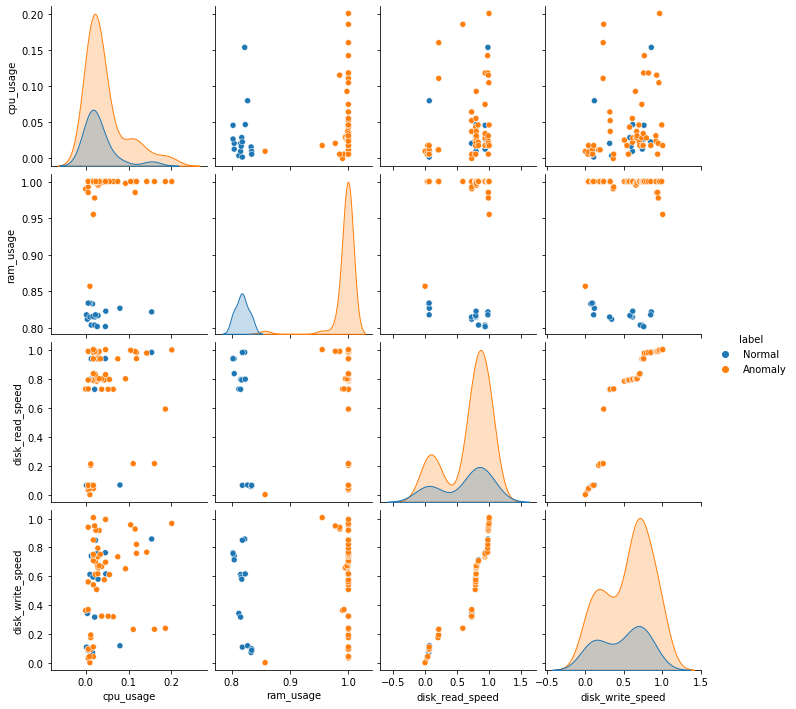

Confusion Matrix:
[[53  0]
 [ 1 17]]

---

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99        53
         1.0       1.00      0.94      0.97        18

    accuracy                           0.99        71
   macro avg       0.99      0.97      0.98        71
weighted avg       0.99      0.99      0.99        71



In [5]:
# Initialize the One-Class SVM model
# nu = upper bound on the fraction of training errors and lower bound on fraction of support vectors
# gamma = kernel coefficient (similar to bandwidth in RBF kernel)
oc_svm = OneClassSVM(kernel='rbf', gamma=0.001, nu=0.05)

# Train the model on training data
oc_svm.fit(X_train)

# Predict anomalies on the test data
predictions = oc_svm.predict(X_test)

# Separate anomalies and normal data for visualization
anomalies = test_data[predictions == -1] # -1 for anomalies
normal = test_data[predictions == 1] # 1 for normal

# Combine normal and anomalies data with a label for easier plotting
sns.pairplot(
    data=pd.concat([normal.assign(label='Normal'), anomalies.assign(label='Anomaly')]),
    hue='label',
    vars=['cpu_usage', 'ram_usage', 'disk_read_speed', 'disk_write_speed'])
plt.show()

# Confusion Matrix
y_pred = np.where(predictions == 1, 1, 0)
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
print("\n---\n")

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred))

Best Parameters:
{'y_pred': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0]), 'gamma': 0.1, 'kernel': 'rbf', 'nu': 0.001, 'accuracy': 0.9859154929577465, 'precision': 1.0, 'recall': 0.9444444444444444, 'f1_score': 0.9714285714285714}

All Results:
    gamma   kernel     nu  accuracy  precision    recall  f1_score
0   0.001      rbf  0.001  0.746479   0.000000  0.000000  0.000000
1   0.005      rbf  0.001  0.971831   1.000000  0.888889  0.941176
2   0.010      rbf  0.001  0.971831   1.000000  0.888889  0.941176
3   0.100      rbf  0.001  0.985915   1.000000  0.944444  0.971429
4   0.500      rbf  0.001  0.985915   1.000000  0.944444  0.971429
..    ...      ...    ...       ...        ...       ...       ...
95  0.001  sigmoid  0.500  0.112676   0.131148  0.444444  0.202532
96  0.005  sigmoid  0.5

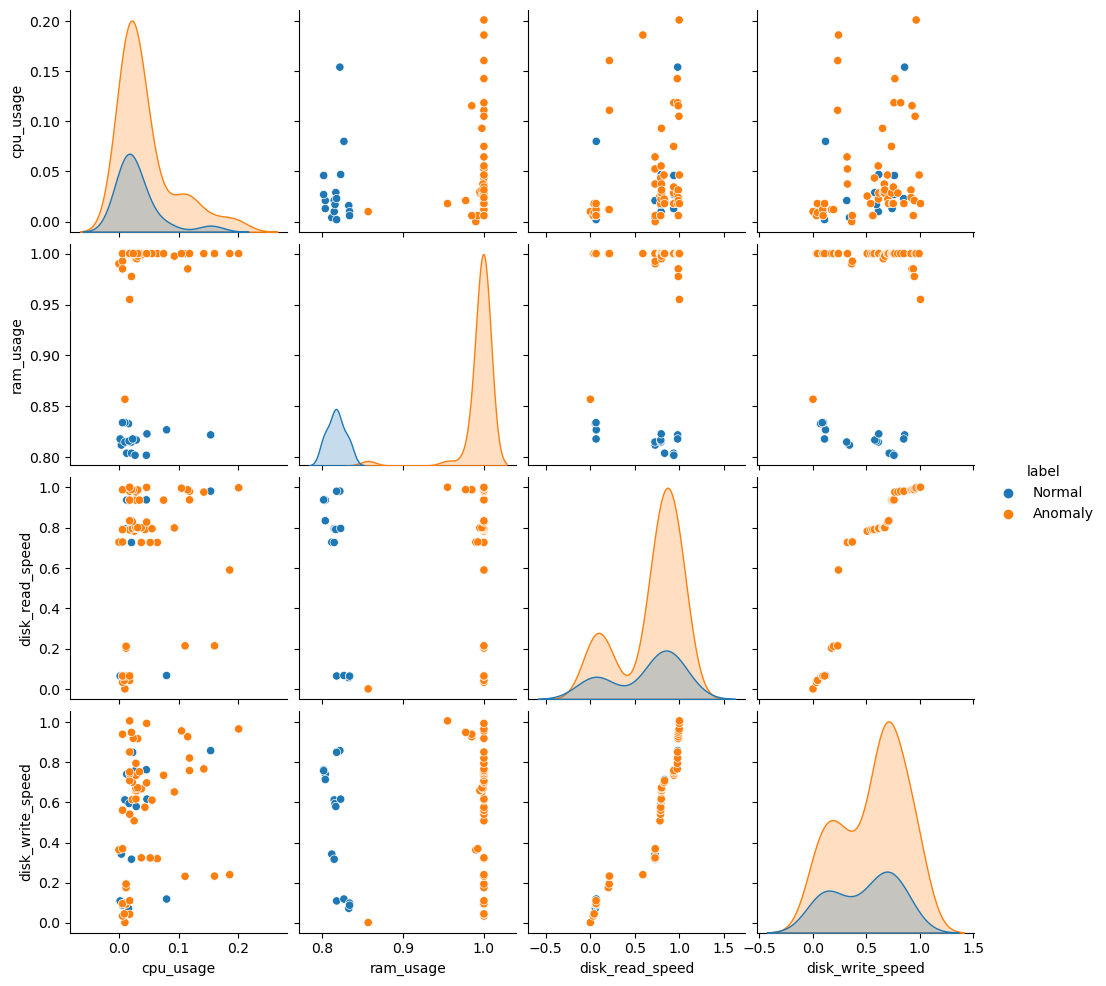

In [6]:
# Define ranges for hyperparameters
from typing import List
from typing_extensions import Literal
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# Define ranges for hyperparameters
nu_list = [0.001, 0.01, 0.05, 0.1, 0.5]
kernel_list: List[Literal['linear', 'poly', 'rbf', 'sigmoid']] = ['rbf', 'linear', 'poly', 'sigmoid']
gamma_list = [0.001, 0.005, 0.01, 0.1, 0.5]

# Initialize results list
results = []
best_f1 = 0

for kernel in kernel_list:
    for nu in nu_list:
        for gamma in gamma_list:
            # Initialize the One-Class SVM model
            oc_svm = OneClassSVM(
                kernel=kernel,
                gamma=gamma,
                nu=nu,
            )

            # Train the model
            oc_svm.fit(X_train)
            
            # Predict anomalies
            predictions = oc_svm.predict(X_test)
            
            y_pred = np.where(predictions == 1, 1, 0)
            
            # Calculate performance metrics
            conf_matrix = confusion_matrix(y_true, y_pred)

            accuracy = accuracy_score(y_true, y_pred)
            precision = precision_score(y_true, y_pred, zero_division=0)
            recall = recall_score(y_true, y_pred, zero_division=0)
            f1 = f1_score(y_true, y_pred, zero_division=0)

            results.append({
                'y_pred': y_pred,
                'gamma': gamma,
                'kernel': kernel,
                'nu': nu,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1
            })

            if f1 > best_f1:
                best_f1 = f1
                best_params = {
                    'y_pred': y_pred,
                    'gamma': gamma,
                    'kernel': kernel,
                    'nu': nu,
                    'accuracy': accuracy,
                    'precision': precision,
                    'recall': recall,
                    'f1_score': f1
                }

# Print the best parameters
print("Best Parameters:")
print(best_params)

# Convert results to a DataFrame for analysis
results_df = pd.DataFrame(results)
print("\nAll Results:")
print(results_df.drop(['y_pred'], axis=1))

# Sort the DataFrame by 'f1_score' in descending order
results_df_sorted = results_df.sort_values(by='f1_score', ascending=False)

# Print the top results
print("\nTop Results:")
print(results_df_sorted.drop(['y_pred'], axis=1).head(35))

# Confusion Matrix of the best model
conf_matrix = confusion_matrix(y_true, best_params['y_pred'])
print("\nConfusion Matrix of the best model:")
print(conf_matrix)

# Pairplot of the best model
anomalies = test_data[best_params['y_pred'] == 0] # 0 for anomalies
normal = test_data[best_params['y_pred'] == 1] # 1 for normal
sns.pairplot(
    data=pd.concat([normal.assign(label='Normal'), anomalies.assign(label='Anomaly')]),
    hue='label',
    vars=['cpu_usage', 'ram_usage', 'disk_read_speed', 'disk_write_speed'])
plt.show()
